#Частина 2
В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [ ]:
! pip install livelossplot

In [ ]:
import livelossplot

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot

from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img
from keras import optimizers
from keras.optimizers.legacy import SGD, Adam
from keras.callbacks import EarlyStopping

In [ ]:
def define_base(educ: bool = False):
    conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
    if educ:
        conv_base.trainable = True
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == "block5_conv1":
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
    else:
        conv_base.trainable = False
    return conv_base

In [ ]:
conv_base = define_base()
conv_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
def define_model(conv_base, opt_name: str = 'SGD', learning_rate: float = None, educ: bool = False):

    if not educ:
        conv_base.trainable = False

    model = models.Sequential([
      conv_base,
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(10, activation="softmax"),
    ])

    opt = opt_name.upper()
    if opt is None or opt == 'SGD':
        lr = 0.01 if learning_rate is None else learning_rate
        opt = SGD(learning_rate=lr, momentum=0.9)
    elif opt == 'ADAM':
        lr = 0.001 if learning_rate is None else learning_rate
        opt = Adam(learning_rate=lr)
    print(f'optimizer: {opt_name}, learning_rate: {learning_rate}')

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
label_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def display_some_examples(examples, labels, predicts=None, label_name=None):
    lab1 = tf.math.argmax(labels, axis=1).numpy()
    if predicts is not None:
      pred1 = tf.math.argmax(predicts, axis=1).numpy()

    pyplot.figure(figsize=(13,13))

    for i in range(15):

        idx = np.random.randint(0, examples.shape[0]-1)
        img = examples[idx]

        label = str(lab1[idx])
        if label_name is not None:
          label = f'{label} ({label_name[lab1[idx]]})'
        if predicts is not None:
          label = f'{label} / {pred1[idx]}'
          if label_name is not None:
            label = f'{label} ({label_name[pred1[idx]]})'

        pyplot.subplot(5,5,i+1)
        pyplot.title(label)
        pyplot.tight_layout()
        pyplot.imshow(img, cmap='gray')

    pyplot.show()

In [ ]:
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
print('Original shape:', trainX.shape, testX.shape)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
trainX, testX = trainX.reshape([-1, 784]), testX.reshape([-1, 784])
print('Vectorize shape:', trainX.shape, testX.shape)

# Convert the images into 3 channels
trainX=np.dstack([trainX] * 3)
testX=np.dstack([testX]*3)
print('Convert into 3 channels:', trainX.shape,testX.shape)

# Reshape images as per the tensor format required by tensorflow
trainX = trainX.reshape(-1, 28,28,3)
testX= testX.reshape (-1,28,28,3)
print('Reshape into tensor format:', trainX.shape,testX.shape)

# Resize the images 48*48 as required by VGG16
trainX = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in trainX])
testX = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in testX])
print('Resize the images 48*48:', trainX.shape, testX.shape)

trainY = to_categorical(trainY)
testY = to_categorical(testY)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

4422102/4422102 [==============================] - 1s 0us/step
Original shape: (60000, 28, 28) (10000, 28, 28)
Vectorize shape: (60000, 784) (10000, 784)
Convert into 3 channels: (60000, 784, 3) (10000, 784, 3)
Reshape into tensor format: (60000, 28, 28, 3) (10000, 28, 28, 3)
Resize the images 48*48: (60000, 48, 48, 3) (10000, 48, 48, 3)


In [ ]:
# trainX = preprocess_input(trainX)
# testX  = preprocess_input (testX)
# print('preprocess_input:', trainX.shape, testX.shape)

## Модель з VGG16 в якості згорткової основи, без донавчання.
#### Оптимізатор SGD, learning_rate: 0.01

In [ ]:
model_0 = define_model(conv_base, opt_name='SGD', learning_rate=0.01)

optimizer: SGD, learning_rate: 0.01


In [ ]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14781642 (56.39 MB)
Trainable params: 66954 (261.54 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


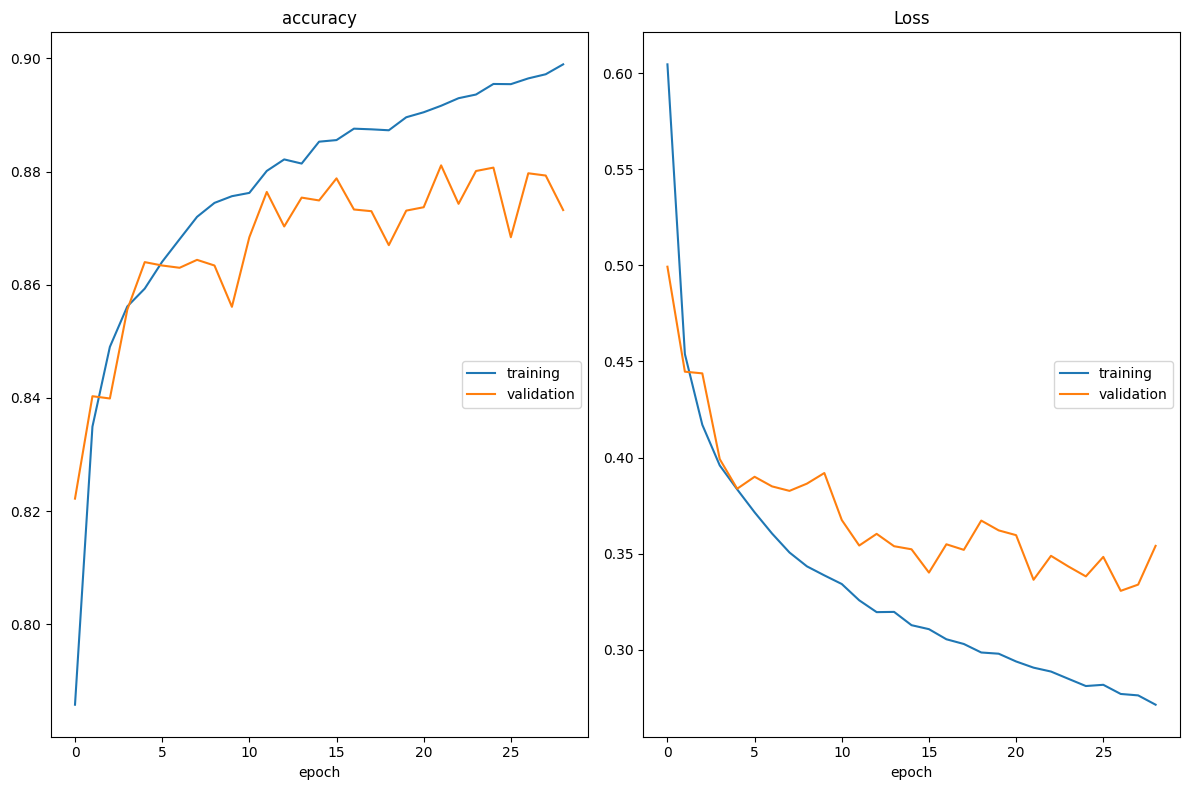

accuracy
	training         	 (min:    0.786, max:    0.899, cur:    0.899)
	validation       	 (min:    0.822, max:    0.881, cur:    0.873)
Loss
	training         	 (min:    0.271, max:    0.605, cur:    0.271)
	validation       	 (min:    0.331, max:    0.499, cur:    0.354)
938/938 [==============================] - 20s 22ms/step - loss: 0.2714 - accuracy: 0.8989 - val_loss: 0.3540 - val_accuracy: 0.8732


In [ ]:
plot_losses_0 = livelossplot.PlotLossesKeras()
estop = EarlyStopping(monitor='val_accuracy', mode='max', patience=7, start_from_epoch=7, restore_best_weights=True)
history_0 = model_0.fit(trainX, trainY,
                        epochs=50,
                        batch_size=64,
                        # callbacks=[plot_losses_0],
                        callbacks=[plot_losses_0, estop],
                        # validation_split=0.2,
                        validation_data=(testX, testY)
                       )

In [ ]:
_, acc = model_0.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 88.110


In [ ]:
loss = history_0.history['loss']
accu = history_0.history['accuracy']
v_loss = history_0.history['val_loss']
v_accu = history_0.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 60.454%, accuracy: 78.578%,  val_loss: 49.927%, val_accuracy: 82.220%
epochs:  2, loss: 45.385%, accuracy: 83.492%,  val_loss: 44.466%, val_accuracy: 84.030%
epochs:  3, loss: 41.704%, accuracy: 84.902%,  val_loss: 44.378%, val_accuracy: 83.990%
epochs:  4, loss: 39.590%, accuracy: 85.617%,  val_loss: 39.918%, val_accuracy: 85.560%
epochs:  5, loss: 38.343%, accuracy: 85.932%,  val_loss: 38.376%, val_accuracy: 86.400%
epochs:  6, loss: 37.150%, accuracy: 86.407%,  val_loss: 38.999%, val_accuracy: 86.340%
epochs:  7, loss: 36.047%, accuracy: 86.805%,  val_loss: 38.499%, val_accuracy: 86.300%
epochs:  8, loss: 35.060%, accuracy: 87.200%,  val_loss: 38.266%, val_accuracy: 86.440%
epochs:  9, loss: 34.340%, accuracy: 87.447%,  val_loss: 38.642%, val_accuracy: 86.340%
epochs: 10, loss: 33.869%, accuracy: 87.565%,  val_loss: 39.194%, val_accuracy: 85.610%
epochs: 11, loss: 33.420%, accuracy: 87.623%,  val_loss: 36.750%, val_accuracy: 86.840%
epochs: 12, loss: 32.573%, accur

In [ ]:
pred_0 = model_0.predict(testX)

313/313 [==============================] - 4s 11ms/step


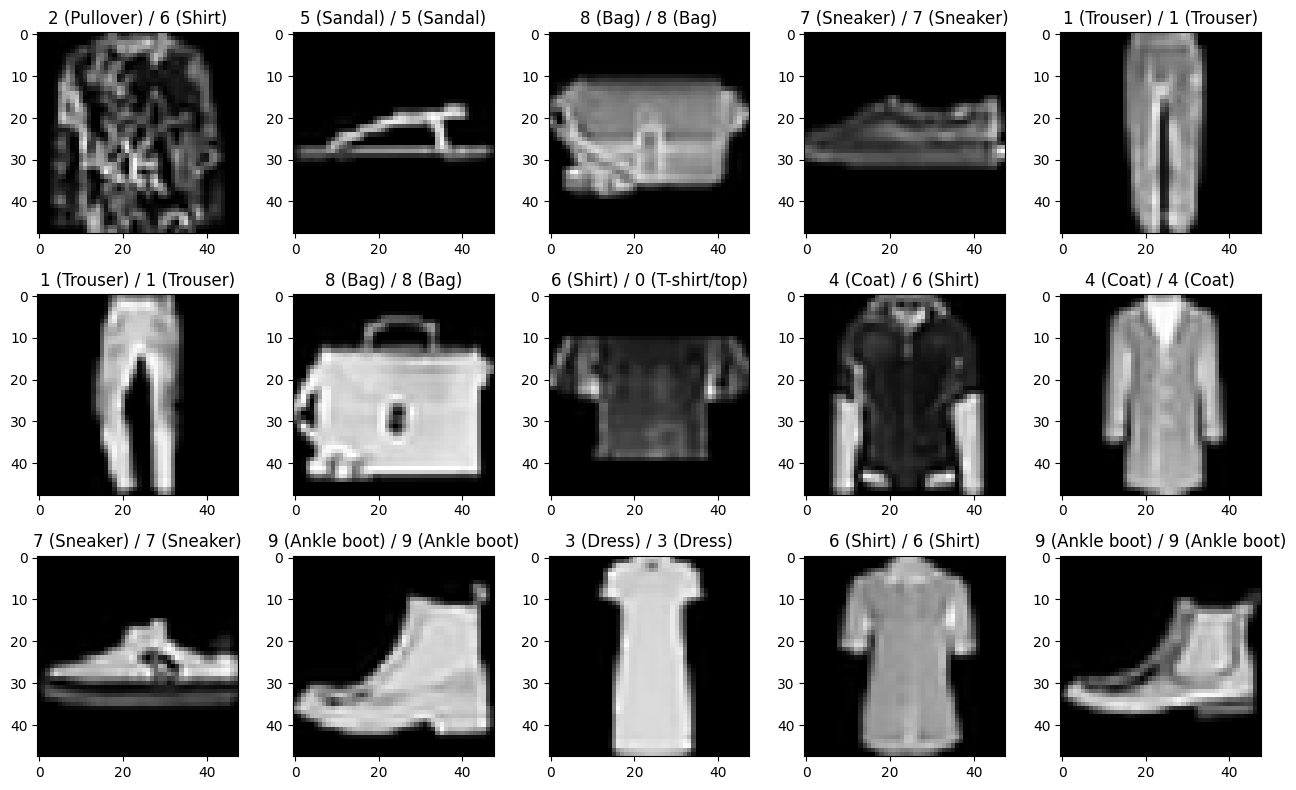

In [ ]:
display_some_examples(testX, testY, pred_0, label_name=label_name)

val_accuracy: 88.110

### Модель з VGG16 в якості згорткової основи, без донавчання.
#### Оптимізатор Adam, learning_rate: 0.001

In [ ]:
model_0a = define_model(conv_base, opt_name='Adam', learning_rate = 0.001)

optimizer: Adam, learning_rate: 0.001


In [ ]:
model_0a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14781642 (56.39 MB)
Trainable params: 66954 (261.54 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


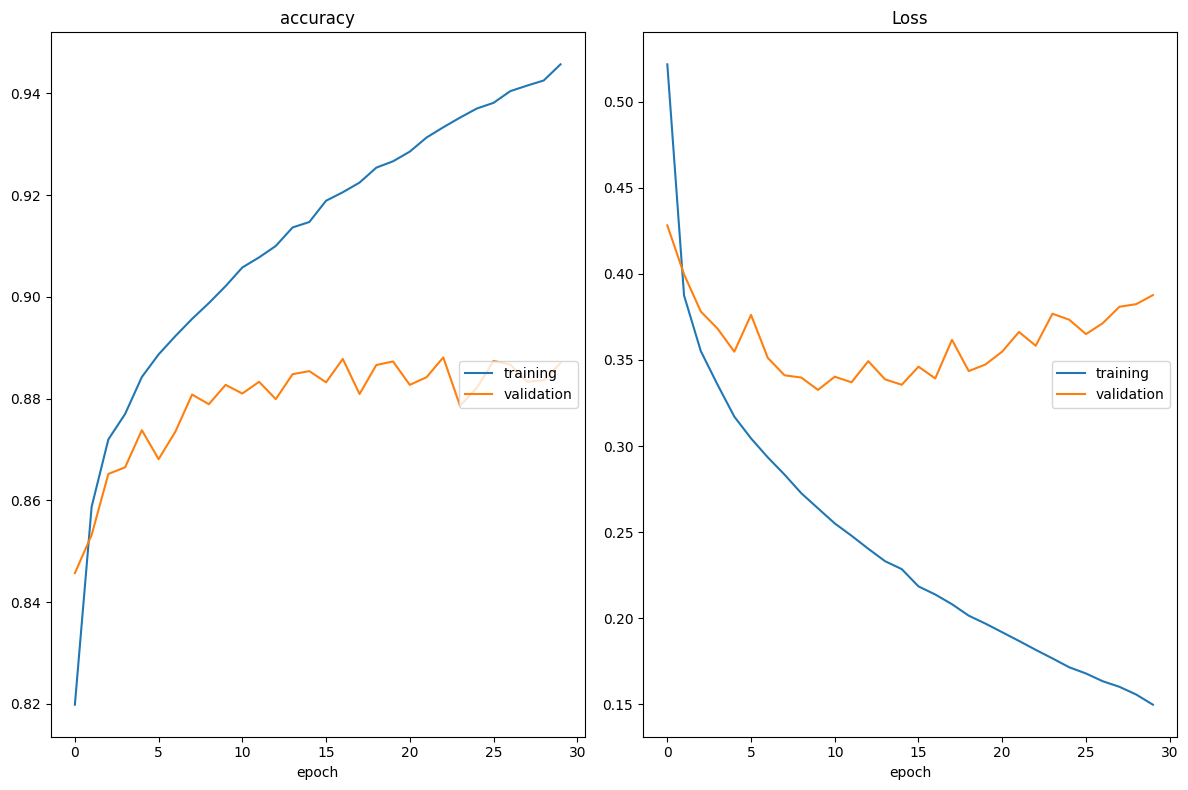

accuracy
	training         	 (min:    0.820, max:    0.946, cur:    0.946)
	validation       	 (min:    0.846, max:    0.888, cur:    0.887)
Loss
	training         	 (min:    0.150, max:    0.522, cur:    0.150)
	validation       	 (min:    0.333, max:    0.428, cur:    0.388)
938/938 [==============================] - 23s 25ms/step - loss: 0.1498 - accuracy: 0.9457 - val_loss: 0.3877 - val_accuracy: 0.8870


In [ ]:
plot_losses_0a = livelossplot.PlotLossesKeras()
estop = EarlyStopping(monitor='val_accuracy', mode='max', patience=7, start_from_epoch=7, restore_best_weights=True)
history_0a = model_0a.fit(trainX, trainY,
                          epochs=32,
                          batch_size=64,
                        #   callbacks=[plot_losses_0a],
                          callbacks=[plot_losses_0a, estop],
                          # validation_split=0.2,
                          validation_data=(testX, testY)
                        )

In [ ]:
_, acc = model_0a.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 88.810


In [ ]:
loss = history_0a.history['loss']
accu = history_0a.history['accuracy']
v_loss = history_0a.history['val_loss']
v_accu = history_0a.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 52.163%, accuracy: 81.985%,  val_loss: 42.814%, val_accuracy: 84.570%
epochs:  2, loss: 38.742%, accuracy: 85.873%,  val_loss: 39.967%, val_accuracy: 85.320%
epochs:  3, loss: 35.514%, accuracy: 87.198%,  val_loss: 37.812%, val_accuracy: 86.520%
epochs:  4, loss: 33.561%, accuracy: 87.698%,  val_loss: 36.819%, val_accuracy: 86.650%
epochs:  5, loss: 31.710%, accuracy: 88.425%,  val_loss: 35.480%, val_accuracy: 87.380%
epochs:  6, loss: 30.443%, accuracy: 88.868%,  val_loss: 37.618%, val_accuracy: 86.810%
epochs:  7, loss: 29.343%, accuracy: 89.228%,  val_loss: 35.119%, val_accuracy: 87.350%
epochs:  8, loss: 28.343%, accuracy: 89.567%,  val_loss: 34.109%, val_accuracy: 88.080%
epochs:  9, loss: 27.262%, accuracy: 89.877%,  val_loss: 33.976%, val_accuracy: 87.890%
epochs: 10, loss: 26.382%, accuracy: 90.210%,  val_loss: 33.260%, val_accuracy: 88.270%
epochs: 11, loss: 25.508%, accuracy: 90.577%,  val_loss: 34.027%, val_accuracy: 88.100%
epochs: 12, loss: 24.793%, accur

In [ ]:
pred_0a = model_0a.predict(testX)

313/313 [==============================] - 4s 11ms/step


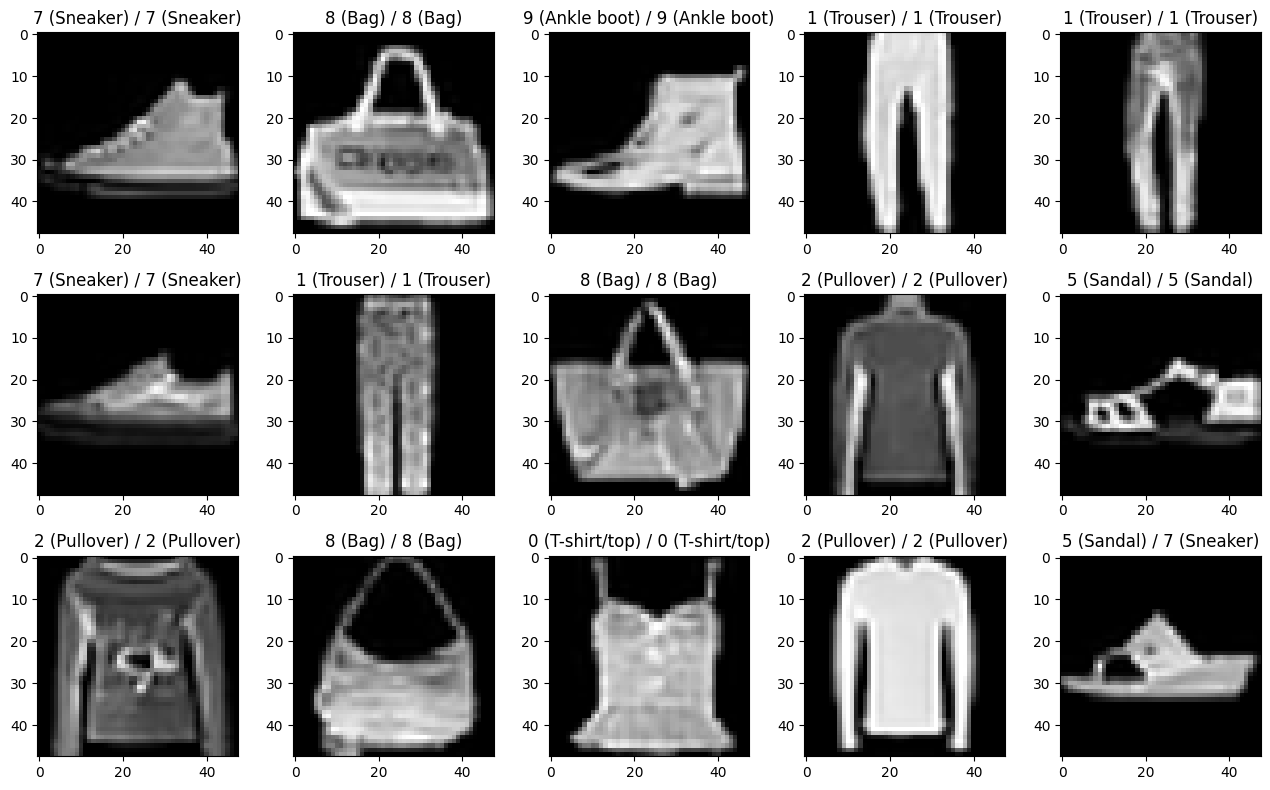

In [ ]:
display_some_examples(testX, testY, pred_0a, label_name=label_name)

val_accuracy: 88.810

###Донавчання останніх трьох шарів vgg16  
#### Оптимізатор Adam, learning_rate: 2e-05


In [ ]:
conv_base1 = define_base(educ=True)     # включаемо донавчання трьох останніх шарів
conv_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
model_0b = define_model(conv_base1, opt_name='Adam', learning_rate = 0.00002, educ=True)
model_0b.summary()

optimizer: Adam, learning_rate: 2e-05
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14781642 (56.39 MB)
Trainable params: 7146378 (27.26 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


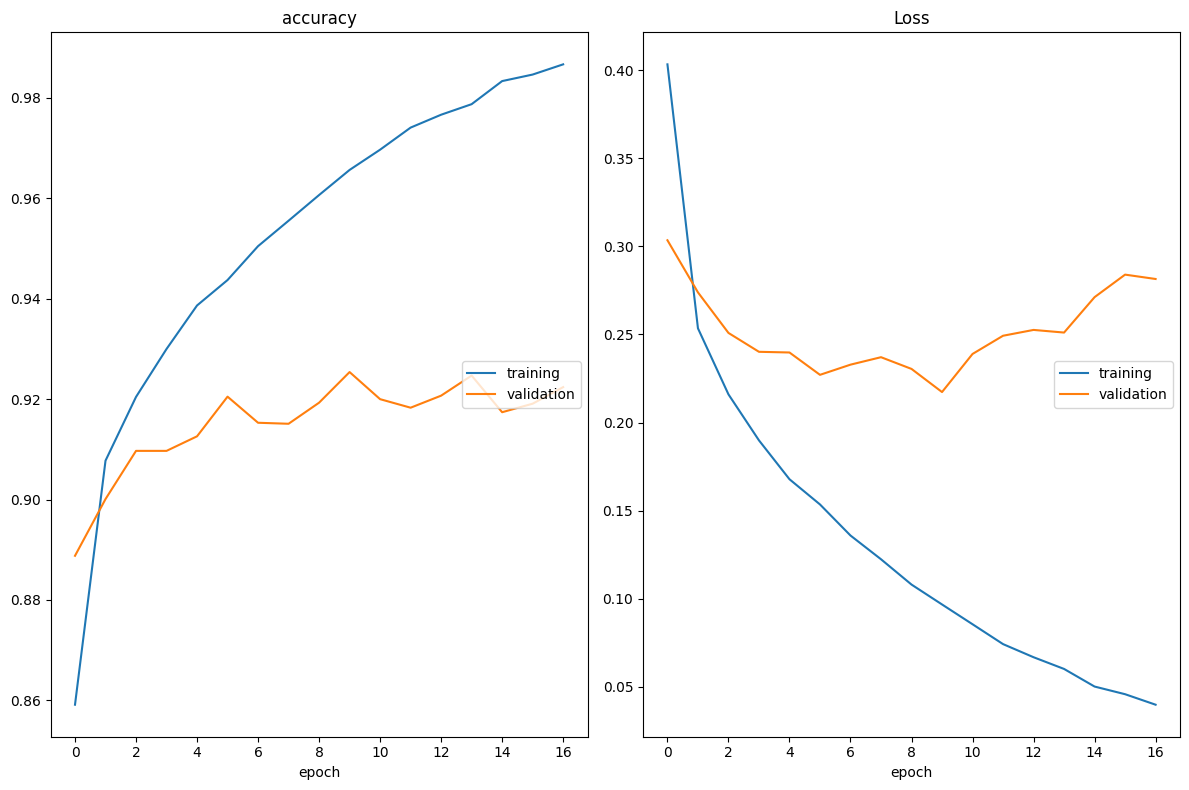

accuracy
	training         	 (min:    0.859, max:    0.987, cur:    0.987)
	validation       	 (min:    0.889, max:    0.925, cur:    0.922)
Loss
	training         	 (min:    0.040, max:    0.403, cur:    0.040)
	validation       	 (min:    0.217, max:    0.303, cur:    0.281)
938/938 [==============================] - 31s 33ms/step - loss: 0.0398 - accuracy: 0.9867 - val_loss: 0.2815 - val_accuracy: 0.9224


In [ ]:
plot_losses_0b = livelossplot.PlotLossesKeras()
estop = EarlyStopping(monitor='val_accuracy', mode='max', patience=7, start_from_epoch=7, restore_best_weights=True)
history_0b = model_0b.fit(trainX, trainY,
                          epochs=50,
                          batch_size=64,
                          #   callbacks=[plot_losses_0a],
                          callbacks=[plot_losses_0b, estop],
                        #   validation_split=0.2,
                          validation_data=(testX, testY)
                         )

In [ ]:
_, acc = model_0b.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 92.540


In [ ]:
loss = history_0b.history['loss']
accu = history_0b.history['accuracy']
v_loss = history_0b.history['val_loss']
v_accu = history_0b.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 40.205%, accuracy: 85.735%,  val_loss: 29.402%, val_accuracy: 89.410%
epochs:  2, loss: 25.064%, accuracy: 90.792%,  val_loss: 25.851%, val_accuracy: 90.420%
epochs:  3, loss: 21.400%, accuracy: 92.163%,  val_loss: 25.844%, val_accuracy: 90.250%
epochs:  4, loss: 18.725%, accuracy: 93.088%,  val_loss: 23.297%, val_accuracy: 91.400%
epochs:  5, loss: 16.752%, accuracy: 93.925%,  val_loss: 21.836%, val_accuracy: 91.900%
epochs:  6, loss: 14.988%, accuracy: 94.567%,  val_loss: 24.325%, val_accuracy: 91.510%
epochs:  7, loss: 13.697%, accuracy: 95.063%,  val_loss: 23.693%, val_accuracy: 91.840%
epochs:  8, loss: 12.023%, accuracy: 95.698%,  val_loss: 22.415%, val_accuracy: 91.880%
epochs:  9, loss: 10.774%, accuracy: 96.125%,  val_loss: 24.162%, val_accuracy: 91.640%
epochs: 10, loss:  9.520%, accuracy: 96.575%,  val_loss: 24.426%, val_accuracy: 91.670%
epochs: 11, loss:  8.441%, accuracy: 96.958%,  val_loss: 23.683%, val_accuracy: 92.120%
epochs: 12, loss:  7.344%, accur

val_accuracy: 92.540

###Донавчання останніх трьох шарів vgg16  
#### Оптимізатор SGD, learning_rate: 0.0002

In [ ]:
conv_base2 = define_base(educ=True)     # включаемо донавчання трьох останніх шарів
conv_base2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
model_2 = define_model(conv_base2, opt_name='SGD', learning_rate = 0.0002, educ=True)
model_2.summary()

optimizer: SGD, learning_rate: 0.0002
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14781642 (56.39 MB)
Trainable params: 7146378 (27.26 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


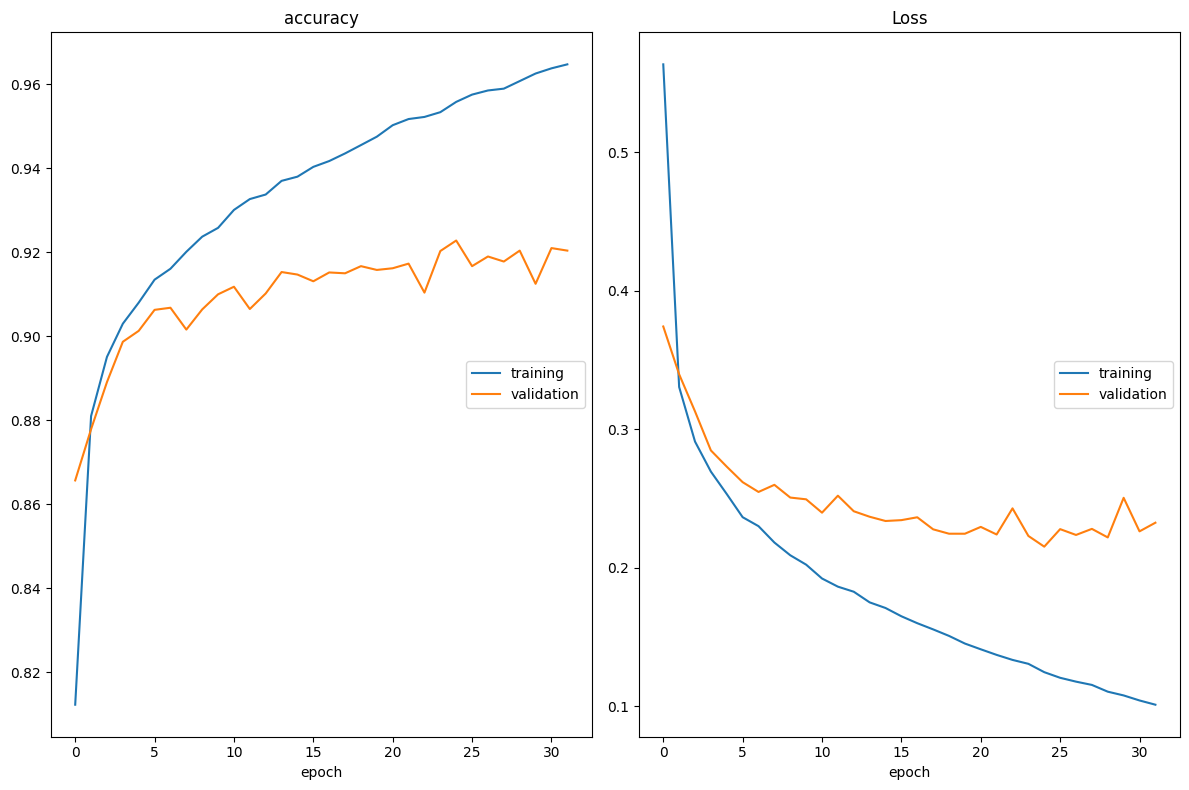

accuracy
	training         	 (min:    0.812, max:    0.965, cur:    0.965)
	validation       	 (min:    0.866, max:    0.923, cur:    0.920)
Loss
	training         	 (min:    0.101, max:    0.563, cur:    0.101)
	validation       	 (min:    0.215, max:    0.374, cur:    0.232)
938/938 [==============================] - 30s 32ms/step - loss: 0.1011 - accuracy: 0.9647 - val_loss: 0.2324 - val_accuracy: 0.9204


In [ ]:
plot_losses_2 = livelossplot.PlotLossesKeras()
estop = EarlyStopping(monitor='val_accuracy', mode='max', patience=7, start_from_epoch=7, restore_best_weights=True)
history_2 = model_2.fit(trainX, trainY,
                          epochs=50,
                          batch_size=64,
                          #   callbacks=[plot_losses_0a],
                          callbacks=[plot_losses_2, estop],
                        #   validation_split=0.2,
                          validation_data=(testX, testY)
                         )

In [ ]:
_, acc = model_2.evaluate(testX, testY, verbose=0)
print('>val_accuracy: %.3f' % (acc * 100.0))

>val_accuracy: 92.280


In [ ]:
loss = history_2.history['loss']
accu = history_2.history['accuracy']
v_loss = history_2.history['val_loss']
v_accu = history_2.history['val_accuracy']
for i in range(len(loss)):
    s = 'epochs: {:>2d}, loss: {:>7.3%}, accuracy: {:.3%},  val_loss: {:.3%}, val_accuracy: {:.3%}'.format((i+1), (loss[i]), (accu[i]), (v_loss[i]), (v_accu[i]))
    print(s)

epochs:  1, loss: 56.329%, accuracy: 81.232%,  val_loss: 37.407%, val_accuracy: 86.570%
epochs:  2, loss: 33.040%, accuracy: 88.102%,  val_loss: 33.957%, val_accuracy: 87.790%
epochs:  3, loss: 29.100%, accuracy: 89.510%,  val_loss: 31.277%, val_accuracy: 88.910%
epochs:  4, loss: 26.932%, accuracy: 90.300%,  val_loss: 28.461%, val_accuracy: 89.870%
epochs:  5, loss: 25.312%, accuracy: 90.802%,  val_loss: 27.289%, val_accuracy: 90.130%
epochs:  6, loss: 23.642%, accuracy: 91.348%,  val_loss: 26.171%, val_accuracy: 90.630%
epochs:  7, loss: 22.994%, accuracy: 91.608%,  val_loss: 25.464%, val_accuracy: 90.680%
epochs:  8, loss: 21.813%, accuracy: 92.012%,  val_loss: 25.978%, val_accuracy: 90.160%
epochs:  9, loss: 20.894%, accuracy: 92.372%,  val_loss: 25.059%, val_accuracy: 90.640%
epochs: 10, loss: 20.216%, accuracy: 92.582%,  val_loss: 24.932%, val_accuracy: 91.000%
epochs: 11, loss: 19.216%, accuracy: 93.008%,  val_loss: 23.968%, val_accuracy: 91.180%
epochs: 12, loss: 18.628%, accur

val_accuracy: 92.280

## Модель з VGG16 в якості згорткової основи, без донавчання.
#### Оптимізатор SGD, learning_rate: 0.01
Досягнута точність 88.11%  
## Модель з VGG16 в якості згорткової основи, без донавчання.
#### Оптимізатор Adam, learning_rate: 0.001
Досягнута точність 88.81%
##Донавчання останніх трьох шарів vgg16  
#### Оптимізатор Adam, learning_rate: 0.00002
Досягнута точність 92.54%
##Донавчання останніх трьох шарів vgg16  
#### Оптимізатор SGD, learning_rate: 0.0002
Досягнута точність 92.28%
